In [1]:
import pandas as pd
import math
from datetime import date
import glob
import json
import numpy as np
import nbimporter
import sys
import numpy as np
import traceback
from os.path import exists
from datetime import timedelta

In [2]:
def load_data(file):
    daily = pd.read_csv(file)
    if 'Date' in daily.columns:
        daily['Date'] = pd.to_datetime(daily['Date'])
    else:
        daily['Date'] = pd.to_datetime(daily['Datetime'], utc=True).dt.tz_convert('US/Eastern')
    daily = daily.sort_values(by='Date', ascending=True)
    daily['Day'] = daily['Date'].dt.strftime('%m/%d/%Y')
    daily['Time'] = daily['Date'].dt.strftime('%H:%M')
    daily = daily.dropna().reset_index(drop=True)
    return daily

def load_yahoo_data(file):
    daily = pd.read_csv(file)
    if 'Date' in daily.columns:
        daily['Date'] = pd.to_datetime(daily['Date'])
    else:
        daily['Date'] = pd.to_datetime(daily['Datetime'], utc=True).dt.tz_convert('US/Eastern')
    daily = daily.sort_values(by='Date', ascending=True)
    daily['Day'] = daily['Date'].dt.strftime('%Y-%m-%d')
    daily['Time'] = daily['Date'].dt.strftime('%H:%M')
    daily = daily.dropna().reset_index(drop=True)
    return daily
def load_NKE_data():
    files = ["/Users/partha/Downloads/0-DTE/Stocks/NKE-20Year.csv",
            
            ]
    df = pd.DataFrame()
    for file in files:
        print ('Loading file {}'.format(file))
        df = df.append(load_data(file))
    df = df.drop_duplicates().sort_values(by='Date', ascending=True)
    return df

def load_stock_data(files):
    df = pd.DataFrame()
    for file in files:
        print ('Loading file {}'.format(file))
        df = df.append(load_data(file))
    df = df.drop_duplicates().sort_values(by='Date', ascending=True)
    return df

def load_stocks_data():
    files = ["/Users/partha/Downloads/0-DTE/stocks/GOOG-Dec-16.csv",
#              "/Users/partha/Downloads/0-DTE/indexes/NFLX-Dec-16.csv",
#              "/Users/partha/Downloads/0-DTE/indexes/GOOG-Dec-16.csv"
            ]
    df = pd.DataFrame()
    for file in files:
        print ('Loading file {}'.format(file))
        df = df.append(load_data(file))
        df
    df = df.drop_duplicates().sort_values(by='Date', ascending=True)
    return df
def load_all_5min_spx():
    files = [ 
        "/Users/partha/Downloads/0-DTE/indexes/SPX-Dec-13.csv",
        "/Users/partha/Downloads/0-DTE/indexes/SPX-Dec-16.csv",
        "/Users/partha/Downloads/0-DTE/indexes/SPX-Dec-12.csv",
        "/Users/partha/Downloads/0-DTE/indexes/SPX-Dec-9.csv",
        "/Users/partha/Downloads/0-DTE/indexes/SPX-Dec-8.csv",
            "/Users/partha/Downloads/0-DTE/indexes/SPX-DEC-6.csv",
             "/Users/partha/Downloads/0-DTE/indexes/SPX-DEC-7.csv",
            "/Users/partha/Downloads/0-DTE/indexes/spx-oct-28-snapshot.csv",
        "/Users/partha/Downloads/0-DTE/indexes/SPX-Dec-20.csv",
    "/Users/partha/Downloads/0-DTE/indexes/SPX-Dec-19.csv"]

    df = pd.DataFrame()
    for file in files:
        print ('Loading file {}'.format(file))
        df = df.append(load_data(file))
    df = df[df['Day'] > '08/31/2022']
    return df.drop_duplicates().sort_values(by='Date', ascending=True)
# df = load_all_5min_spx()
# df.head()

def load_5min_vix():
    files = [ 
        "/Users/partha/Downloads/0-DTE/indexes/VIX-Dec-9.csv",
        "/Users/partha/Downloads/0-DTE/indexes/VIX-Nov-09.csv",
        "/Users/partha/Downloads/0-DTE/indexes/VIX-Nov-09.csv"
    ]
    df = pd.DataFrame()
    for file in files:
        print ('Loading file {}'.format(file))
        df = df.append(load_data(file))
    df = df[df['Day'] > '08/31/2022']
    return df.drop_duplicates().sort_values(by='Date', ascending=True)
    
def load_annual_data():
    files = ["/Users/partha/Downloads/0-DTE/indexes/SPX-20Year.csv",
            
            ]
    df = pd.DataFrame()
    for file in files:
        print ('Loading file {}'.format(file))
        df = df.append(load_data(file))
    df = df.drop_duplicates().sort_values(by='Date', ascending=True)
    return df



In [3]:
def build_seq(segment, split_size=10):
    
    rge = segment['High'].max() - segment['Low'].min()
    ilist = np.array_split(segment, split_size)
    amap = []
   
    for idf in ilist:
        try:
            idf = idf.reset_index(drop=True)
            s = int((idf[:1]['Open'].min()-segment['Low'].min())*split_size/rge)
            e = int((idf.iloc[-1]['Close'].min()-segment['Low'].min())*split_size/rge)
            if not amap:
                amap.append(s)
            else:    
                amap.append(e)
        except Exception as e:
            #print ("Exception while building Sequence {}".format(e))
            pass    
    return amap


def predict(amap, seq_map, dates=None, times=None):
    lowest = sys.maxsize
    mystack = []
    match_seq = None
    for seq_key in seq_map.keys():
        seq = seq_map[seq_key]
        aseq = seq['Sequence']
        
        if aseq is None:
            continue
            
        if dates is not None:
            end_date = seq['Start Date']
            if end_date in dates: # and seq['Start Time'] == times[dates.index(end_date)]:
                continue
            else:
                pass

        try:
            dist = np.linalg.norm(np.array(aseq)-np.array(amap))
            if dist == 0:
                continue
                
            if dist < lowest:
                lowest = dist
                match_seq = str(aseq)
                mystack.append(seq)
            
        except Exception as e:
            #print (e)
            pass
    prediction = seq_map[match_seq].copy() if seq else {}
    try:
        prediction['Distance'] = lowest
        #prediction['stack'] = mystack
        pass
    except:
        pass
    return prediction


def test_a_segment(asegment, seqmap, split_size=20):
    asegment = asegment.reset_index(drop=True)
    if len(asegment) != split_size:
        print ("Input size and split size doesn't match {} / {}".format(len(asegment), split_size))
        return
    amap = build_seq(asegment, split_size)
    return predict(amap, seqmap)



In [27]:
class TestUnit:
    
    def __init__(self, df, outcome):
        self.unit = df
        self.outcome = outcome
      
    def test_date(self):
        return self.unit.iloc[-1]['Date']
    
    def test_time(self):
        return self.unit.iloc[-1]['Time']
    
    def to_string(self):
        print (self.unit[0]['Date'], self.unit.iloc[-1]['Date'],h)
        
def getTestUnits(sym, window=20, horizon=10, backtest_days=399):
    df = load_data('/Users/partha/Downloads/0-DTE/indexes/hourly/Hourly-{}-Jan-01.csv'.format(sym))
    df = df[-backtest_days:]
    units = []
    
    for i in range(0, len(df)-(window + horizon - 1)):
        adf = df[i:i+window]
        hdf = df[i+window:i+window+horizon]
        h = 1 if hdf.iloc[-1]['Close'] > adf.iloc[-1]['Close'] else -1
        units.append(TestUnit(adf, h))
    return units

In [136]:
def run_predictions(pdf, match, horizon):
    end = match['End Date']
    end_time = match['End Time']
    pdf = pdf[(pdf['Day'] >= end) & (pdf['Time'] >= end_time)]
    return 1 if pdf.iloc[horizon]['Close'] > pdf.iloc[0]['Open'] else -1

def predict_now(symbols, datetime=None, horizon=10):
    futures = []
    for sym in symbols:
        try:
            model_file = '/Users/partha/Downloads/0-DTE/models/SPX-hourly-Jan05.json'
            pdf = load_data('/Users/partha/Downloads/0-DTE/indexes/hourly/Hourly-{}-Jan-05.csv'.format(sym))
            tdf = load_data('/Users/partha/Downloads/0-DTE/indexes/hourly/Hourly-{}-Jan-05.csv'.format(sym))[-399:]
            model = json.loads(open(model_file).read())
            match = None
            if datetime is None:
                match = test_a_segment(tdf[-20:], model, 20)
            else:
                tdf = tdf[(tdf['Date'] <= datetime)]
                print (tdf.iloc[-1]['Date'])
                match = test_a_segment(tdf[-20:], model, 20)
            prediction = run_predictions(pdf, match, horizon)
            futures.append({'S': sym, 'F': prediction, 'D': match['End Date'], 'T': match['End Time']})
        except Exception as e:
            traceback.print_exc()
            print (e)
            pass
    return pd.DataFrame(futures)

predict_now(['SPX'])


/opt/anaconda3/lib/python3.7/site-packages/dateutil/parser/_parser.py:1218: UnknownTimezoneWarning: tzname ET identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)
/opt/anaconda3/lib/python3.7/site-packages/dateutil/parser/_parser.py:1218: UnknownTimezoneWarning: tzname ET identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)


,S,F,D,T
0,SPX,-1,11/01/2022,11:30


In [126]:
def run_tests(horizon=7):
    predictions = pd.DataFrame()
    symbols = ['SPX']
    tot = len(symbols)
    count = 0
    for sym in symbols:
        try:
            count += 1
            model_file = '/Users/partha/Downloads/0-DTE/models/{}-Hourly.json'.format(sym)
            pdf = load_data('/Users/partha/Downloads/0-DTE/indexes/hourly/Hourly-{}-Jan-01.csv'.format(sym))
            model = json.loads(open(model_file).read())
            units = getTestUnits(sym, horizon=horizon)
            preds = []
            for unit in units:
                try:
                    match = test_a_segment(unit.unit, model, 20)
                    prediction = run_predictions(pdf, match, horizon)
                    r = {'S': sym, 'D':unit.test_date(), 'T': unit.test_time(), 'A':unit.outcome, 'P': prediction}
                    preds.append(r)
                except Exception as e:
                    pass
            preds = pd.DataFrame(preds)
            preds['O'] = (preds.A + preds.P)/2
            preds['D'] = preds['D'].dt.strftime('%Y-%m-%d')
            predictions = predictions.append(preds)
            print ('{}/{} {} {}'.format(count, tot, sym, len(preds[preds['O'] != 0.0])/len(preds)))
        except Exception as e:
            print (e)
            pass
    return predictions

def run_p_profile(df):
    pdf = []
    for key, gr in df.groupby(['S']):
        pdf.append({'S': key, 'Rate': len(gr[gr['A'] == gr['P']])/len(gr)})
    pdf = pd.DataFrame(pdf).sort_values(by=['Rate'], ascending=False)
    return pdf



In [127]:
odf = run_tests(horizon=7)

odf[-50:]

/opt/anaconda3/lib/python3.7/site-packages/dateutil/parser/_parser.py:1218: UnknownTimezoneWarning: tzname ET identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)
/opt/anaconda3/lib/python3.7/site-packages/dateutil/parser/_parser.py:1218: UnknownTimezoneWarning: tzname ET identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)


1/1 SPX 0.5388739946380697


,S,D,T,A,P,O
323,SPX,2022-12-19,15:30,1,1,1.0
324,SPX,2022-12-20,09:30,1,1,1.0
325,SPX,2022-12-20,10:30,1,1,1.0
326,SPX,2022-12-20,11:30,1,1,1.0
327,SPX,2022-12-20,12:30,1,-1,0.0
328,SPX,2022-12-20,13:30,1,-1,0.0
329,SPX,2022-12-20,14:30,1,1,1.0
330,SPX,2022-12-20,15:30,1,1,1.0
331,SPX,2022-12-21,09:30,-1,1,0.0
332,SPX,2022-12-21,10:30,-1,1,0.0


In [128]:
times = odf['T'].unique()
for t in times:
    print (t, len(odf[(odf['T'] == t) & (odf['O'] != 0.0)])/len(odf[odf['T'] == t]), len(odf[(odf['T'] == t) & (odf['O'] != 0.0)]), len(odf[odf['T'] == t]))

13:30 0.46296296296296297 25 54
14:30 0.5925925925925926 32 54
15:30 0.660377358490566 35 53
09:30 0.5849056603773585 31 53
10:30 0.49056603773584906 26 53
11:30 0.4716981132075472 25 53
12:30 0.5094339622641509 27 53


In [116]:
len(odf[(odf['T'] == '15:30') & (odf['O'] != 0.0)])/len(odf[(odf['T'] == '15:30')])

0.6538461538461539

In [123]:
tdf = load_data('/Users/partha/Downloads/0-DTE/indexes/hourly/Hourly-{}-Jan-01.csv'.format('SPX'))[-399:]
#tdf = tdf[(tdf['Date'] <= '2022-11-28 15:30')]
print (tdf.iloc[-1]['Date'])

2022-12-30 15:30:00


/opt/anaconda3/lib/python3.7/site-packages/dateutil/parser/_parser.py:1218: UnknownTimezoneWarning: tzname ET identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)


In [93]:
for d in odf['D'].unique():
    predict_now(['SPX'], )

/opt/anaconda3/lib/python3.7/site-packages/dateutil/parser/_parser.py:1218: UnknownTimezoneWarning: tzname ET identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)
/opt/anaconda3/lib/python3.7/site-packages/dateutil/parser/_parser.py:1218: UnknownTimezoneWarning: tzname ET identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)


2022-11-30 15:30:00
06/24/2022 12/30/2022 06/24/2022 11:30 659 10


,S,F,D,T
0,SPX,-1,06/24/2022,11:30


In [106]:
adf = pd.DataFrame()
for d in odf['D'].unique():
    df = predict_now(['SPX'], '{} 15:30'.format(d))
    df['Date'] = d
    adf = adf.append(df)

/opt/anaconda3/lib/python3.7/site-packages/dateutil/parser/_parser.py:1218: UnknownTimezoneWarning: tzname ET identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)
/opt/anaconda3/lib/python3.7/site-packages/dateutil/parser/_parser.py:1218: UnknownTimezoneWarning: tzname ET identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)


2022-10-13 15:30:00


/opt/anaconda3/lib/python3.7/site-packages/dateutil/parser/_parser.py:1218: UnknownTimezoneWarning: tzname ET identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)
/opt/anaconda3/lib/python3.7/site-packages/dateutil/parser/_parser.py:1218: UnknownTimezoneWarning: tzname ET identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)


2022-10-14 15:30:00


/opt/anaconda3/lib/python3.7/site-packages/dateutil/parser/_parser.py:1218: UnknownTimezoneWarning: tzname ET identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)
/opt/anaconda3/lib/python3.7/site-packages/dateutil/parser/_parser.py:1218: UnknownTimezoneWarning: tzname ET identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)


2022-10-17 15:30:00


/opt/anaconda3/lib/python3.7/site-packages/dateutil/parser/_parser.py:1218: UnknownTimezoneWarning: tzname ET identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)
/opt/anaconda3/lib/python3.7/site-packages/dateutil/parser/_parser.py:1218: UnknownTimezoneWarning: tzname ET identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)


2022-10-18 15:30:00


/opt/anaconda3/lib/python3.7/site-packages/dateutil/parser/_parser.py:1218: UnknownTimezoneWarning: tzname ET identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)
/opt/anaconda3/lib/python3.7/site-packages/dateutil/parser/_parser.py:1218: UnknownTimezoneWarning: tzname ET identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)


2022-10-19 15:30:00


/opt/anaconda3/lib/python3.7/site-packages/dateutil/parser/_parser.py:1218: UnknownTimezoneWarning: tzname ET identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)
/opt/anaconda3/lib/python3.7/site-packages/dateutil/parser/_parser.py:1218: UnknownTimezoneWarning: tzname ET identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)


2022-10-20 15:30:00


/opt/anaconda3/lib/python3.7/site-packages/dateutil/parser/_parser.py:1218: UnknownTimezoneWarning: tzname ET identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)
/opt/anaconda3/lib/python3.7/site-packages/dateutil/parser/_parser.py:1218: UnknownTimezoneWarning: tzname ET identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)


2022-10-21 15:30:00


/opt/anaconda3/lib/python3.7/site-packages/dateutil/parser/_parser.py:1218: UnknownTimezoneWarning: tzname ET identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)
/opt/anaconda3/lib/python3.7/site-packages/dateutil/parser/_parser.py:1218: UnknownTimezoneWarning: tzname ET identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)


2022-10-24 15:30:00


/opt/anaconda3/lib/python3.7/site-packages/dateutil/parser/_parser.py:1218: UnknownTimezoneWarning: tzname ET identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)
/opt/anaconda3/lib/python3.7/site-packages/dateutil/parser/_parser.py:1218: UnknownTimezoneWarning: tzname ET identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)


2022-10-25 15:30:00


/opt/anaconda3/lib/python3.7/site-packages/dateutil/parser/_parser.py:1218: UnknownTimezoneWarning: tzname ET identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)
/opt/anaconda3/lib/python3.7/site-packages/dateutil/parser/_parser.py:1218: UnknownTimezoneWarning: tzname ET identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)


2022-10-26 15:30:00


/opt/anaconda3/lib/python3.7/site-packages/dateutil/parser/_parser.py:1218: UnknownTimezoneWarning: tzname ET identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)
/opt/anaconda3/lib/python3.7/site-packages/dateutil/parser/_parser.py:1218: UnknownTimezoneWarning: tzname ET identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)


2022-10-27 15:30:00


/opt/anaconda3/lib/python3.7/site-packages/dateutil/parser/_parser.py:1218: UnknownTimezoneWarning: tzname ET identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)
/opt/anaconda3/lib/python3.7/site-packages/dateutil/parser/_parser.py:1218: UnknownTimezoneWarning: tzname ET identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)


2022-10-28 15:30:00


/opt/anaconda3/lib/python3.7/site-packages/dateutil/parser/_parser.py:1218: UnknownTimezoneWarning: tzname ET identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)
/opt/anaconda3/lib/python3.7/site-packages/dateutil/parser/_parser.py:1218: UnknownTimezoneWarning: tzname ET identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)


2022-10-31 15:30:00


/opt/anaconda3/lib/python3.7/site-packages/dateutil/parser/_parser.py:1218: UnknownTimezoneWarning: tzname ET identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)
/opt/anaconda3/lib/python3.7/site-packages/dateutil/parser/_parser.py:1218: UnknownTimezoneWarning: tzname ET identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)


2022-11-01 15:30:00


/opt/anaconda3/lib/python3.7/site-packages/dateutil/parser/_parser.py:1218: UnknownTimezoneWarning: tzname ET identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)
/opt/anaconda3/lib/python3.7/site-packages/dateutil/parser/_parser.py:1218: UnknownTimezoneWarning: tzname ET identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)


2022-11-02 15:30:00


/opt/anaconda3/lib/python3.7/site-packages/dateutil/parser/_parser.py:1218: UnknownTimezoneWarning: tzname ET identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)
/opt/anaconda3/lib/python3.7/site-packages/dateutil/parser/_parser.py:1218: UnknownTimezoneWarning: tzname ET identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)


2022-11-03 15:30:00


/opt/anaconda3/lib/python3.7/site-packages/dateutil/parser/_parser.py:1218: UnknownTimezoneWarning: tzname ET identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)
/opt/anaconda3/lib/python3.7/site-packages/dateutil/parser/_parser.py:1218: UnknownTimezoneWarning: tzname ET identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)


2022-11-04 15:30:00


/opt/anaconda3/lib/python3.7/site-packages/dateutil/parser/_parser.py:1218: UnknownTimezoneWarning: tzname ET identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)
/opt/anaconda3/lib/python3.7/site-packages/dateutil/parser/_parser.py:1218: UnknownTimezoneWarning: tzname ET identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)


2022-11-07 15:30:00


/opt/anaconda3/lib/python3.7/site-packages/dateutil/parser/_parser.py:1218: UnknownTimezoneWarning: tzname ET identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)
/opt/anaconda3/lib/python3.7/site-packages/dateutil/parser/_parser.py:1218: UnknownTimezoneWarning: tzname ET identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)


2022-11-08 15:30:00


/opt/anaconda3/lib/python3.7/site-packages/dateutil/parser/_parser.py:1218: UnknownTimezoneWarning: tzname ET identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)
/opt/anaconda3/lib/python3.7/site-packages/dateutil/parser/_parser.py:1218: UnknownTimezoneWarning: tzname ET identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)


2022-11-09 15:30:00


/opt/anaconda3/lib/python3.7/site-packages/dateutil/parser/_parser.py:1218: UnknownTimezoneWarning: tzname ET identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)
/opt/anaconda3/lib/python3.7/site-packages/dateutil/parser/_parser.py:1218: UnknownTimezoneWarning: tzname ET identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)


2022-11-10 15:30:00


/opt/anaconda3/lib/python3.7/site-packages/dateutil/parser/_parser.py:1218: UnknownTimezoneWarning: tzname ET identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)
/opt/anaconda3/lib/python3.7/site-packages/dateutil/parser/_parser.py:1218: UnknownTimezoneWarning: tzname ET identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)


2022-11-11 15:30:00


/opt/anaconda3/lib/python3.7/site-packages/dateutil/parser/_parser.py:1218: UnknownTimezoneWarning: tzname ET identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)
/opt/anaconda3/lib/python3.7/site-packages/dateutil/parser/_parser.py:1218: UnknownTimezoneWarning: tzname ET identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)


2022-11-14 15:30:00


/opt/anaconda3/lib/python3.7/site-packages/dateutil/parser/_parser.py:1218: UnknownTimezoneWarning: tzname ET identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)
/opt/anaconda3/lib/python3.7/site-packages/dateutil/parser/_parser.py:1218: UnknownTimezoneWarning: tzname ET identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)


2022-11-15 15:30:00


/opt/anaconda3/lib/python3.7/site-packages/dateutil/parser/_parser.py:1218: UnknownTimezoneWarning: tzname ET identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)
/opt/anaconda3/lib/python3.7/site-packages/dateutil/parser/_parser.py:1218: UnknownTimezoneWarning: tzname ET identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)


2022-11-16 15:30:00


/opt/anaconda3/lib/python3.7/site-packages/dateutil/parser/_parser.py:1218: UnknownTimezoneWarning: tzname ET identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)
/opt/anaconda3/lib/python3.7/site-packages/dateutil/parser/_parser.py:1218: UnknownTimezoneWarning: tzname ET identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)


2022-11-17 15:30:00


/opt/anaconda3/lib/python3.7/site-packages/dateutil/parser/_parser.py:1218: UnknownTimezoneWarning: tzname ET identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)
/opt/anaconda3/lib/python3.7/site-packages/dateutil/parser/_parser.py:1218: UnknownTimezoneWarning: tzname ET identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)


2022-11-18 15:30:00


/opt/anaconda3/lib/python3.7/site-packages/dateutil/parser/_parser.py:1218: UnknownTimezoneWarning: tzname ET identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)
/opt/anaconda3/lib/python3.7/site-packages/dateutil/parser/_parser.py:1218: UnknownTimezoneWarning: tzname ET identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)


2022-11-21 15:30:00


/opt/anaconda3/lib/python3.7/site-packages/dateutil/parser/_parser.py:1218: UnknownTimezoneWarning: tzname ET identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)
/opt/anaconda3/lib/python3.7/site-packages/dateutil/parser/_parser.py:1218: UnknownTimezoneWarning: tzname ET identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)


2022-11-22 15:30:00


/opt/anaconda3/lib/python3.7/site-packages/dateutil/parser/_parser.py:1218: UnknownTimezoneWarning: tzname ET identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)
/opt/anaconda3/lib/python3.7/site-packages/dateutil/parser/_parser.py:1218: UnknownTimezoneWarning: tzname ET identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)


2022-11-23 15:30:00


/opt/anaconda3/lib/python3.7/site-packages/dateutil/parser/_parser.py:1218: UnknownTimezoneWarning: tzname ET identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)
/opt/anaconda3/lib/python3.7/site-packages/dateutil/parser/_parser.py:1218: UnknownTimezoneWarning: tzname ET identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)


2022-11-25 14:30:00


/opt/anaconda3/lib/python3.7/site-packages/dateutil/parser/_parser.py:1218: UnknownTimezoneWarning: tzname ET identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)
/opt/anaconda3/lib/python3.7/site-packages/dateutil/parser/_parser.py:1218: UnknownTimezoneWarning: tzname ET identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)


2022-11-28 15:30:00


/opt/anaconda3/lib/python3.7/site-packages/dateutil/parser/_parser.py:1218: UnknownTimezoneWarning: tzname ET identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)
/opt/anaconda3/lib/python3.7/site-packages/dateutil/parser/_parser.py:1218: UnknownTimezoneWarning: tzname ET identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)


2022-11-29 15:30:00


/opt/anaconda3/lib/python3.7/site-packages/dateutil/parser/_parser.py:1218: UnknownTimezoneWarning: tzname ET identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)
/opt/anaconda3/lib/python3.7/site-packages/dateutil/parser/_parser.py:1218: UnknownTimezoneWarning: tzname ET identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)


2022-11-30 15:30:00


/opt/anaconda3/lib/python3.7/site-packages/dateutil/parser/_parser.py:1218: UnknownTimezoneWarning: tzname ET identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)
/opt/anaconda3/lib/python3.7/site-packages/dateutil/parser/_parser.py:1218: UnknownTimezoneWarning: tzname ET identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)


2022-12-01 15:30:00


/opt/anaconda3/lib/python3.7/site-packages/dateutil/parser/_parser.py:1218: UnknownTimezoneWarning: tzname ET identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)
/opt/anaconda3/lib/python3.7/site-packages/dateutil/parser/_parser.py:1218: UnknownTimezoneWarning: tzname ET identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)


2022-12-02 15:30:00


/opt/anaconda3/lib/python3.7/site-packages/dateutil/parser/_parser.py:1218: UnknownTimezoneWarning: tzname ET identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)
/opt/anaconda3/lib/python3.7/site-packages/dateutil/parser/_parser.py:1218: UnknownTimezoneWarning: tzname ET identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)


2022-12-05 15:30:00


/opt/anaconda3/lib/python3.7/site-packages/dateutil/parser/_parser.py:1218: UnknownTimezoneWarning: tzname ET identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)
/opt/anaconda3/lib/python3.7/site-packages/dateutil/parser/_parser.py:1218: UnknownTimezoneWarning: tzname ET identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)


2022-12-06 15:30:00


/opt/anaconda3/lib/python3.7/site-packages/dateutil/parser/_parser.py:1218: UnknownTimezoneWarning: tzname ET identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)
/opt/anaconda3/lib/python3.7/site-packages/dateutil/parser/_parser.py:1218: UnknownTimezoneWarning: tzname ET identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)


2022-12-07 15:30:00


/opt/anaconda3/lib/python3.7/site-packages/dateutil/parser/_parser.py:1218: UnknownTimezoneWarning: tzname ET identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)
/opt/anaconda3/lib/python3.7/site-packages/dateutil/parser/_parser.py:1218: UnknownTimezoneWarning: tzname ET identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)


2022-12-08 15:30:00


/opt/anaconda3/lib/python3.7/site-packages/dateutil/parser/_parser.py:1218: UnknownTimezoneWarning: tzname ET identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)
/opt/anaconda3/lib/python3.7/site-packages/dateutil/parser/_parser.py:1218: UnknownTimezoneWarning: tzname ET identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)


2022-12-09 15:30:00


/opt/anaconda3/lib/python3.7/site-packages/dateutil/parser/_parser.py:1218: UnknownTimezoneWarning: tzname ET identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)
/opt/anaconda3/lib/python3.7/site-packages/dateutil/parser/_parser.py:1218: UnknownTimezoneWarning: tzname ET identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)


2022-12-12 15:30:00


/opt/anaconda3/lib/python3.7/site-packages/dateutil/parser/_parser.py:1218: UnknownTimezoneWarning: tzname ET identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)
/opt/anaconda3/lib/python3.7/site-packages/dateutil/parser/_parser.py:1218: UnknownTimezoneWarning: tzname ET identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)


2022-12-13 15:30:00


/opt/anaconda3/lib/python3.7/site-packages/dateutil/parser/_parser.py:1218: UnknownTimezoneWarning: tzname ET identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)
/opt/anaconda3/lib/python3.7/site-packages/dateutil/parser/_parser.py:1218: UnknownTimezoneWarning: tzname ET identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)


2022-12-14 15:30:00


/opt/anaconda3/lib/python3.7/site-packages/dateutil/parser/_parser.py:1218: UnknownTimezoneWarning: tzname ET identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)
/opt/anaconda3/lib/python3.7/site-packages/dateutil/parser/_parser.py:1218: UnknownTimezoneWarning: tzname ET identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)


2022-12-15 15:30:00


/opt/anaconda3/lib/python3.7/site-packages/dateutil/parser/_parser.py:1218: UnknownTimezoneWarning: tzname ET identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)
/opt/anaconda3/lib/python3.7/site-packages/dateutil/parser/_parser.py:1218: UnknownTimezoneWarning: tzname ET identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)


2022-12-16 15:30:00


/opt/anaconda3/lib/python3.7/site-packages/dateutil/parser/_parser.py:1218: UnknownTimezoneWarning: tzname ET identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)
/opt/anaconda3/lib/python3.7/site-packages/dateutil/parser/_parser.py:1218: UnknownTimezoneWarning: tzname ET identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)


2022-12-19 15:30:00


/opt/anaconda3/lib/python3.7/site-packages/dateutil/parser/_parser.py:1218: UnknownTimezoneWarning: tzname ET identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)
/opt/anaconda3/lib/python3.7/site-packages/dateutil/parser/_parser.py:1218: UnknownTimezoneWarning: tzname ET identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)


2022-12-20 15:30:00


/opt/anaconda3/lib/python3.7/site-packages/dateutil/parser/_parser.py:1218: UnknownTimezoneWarning: tzname ET identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)
/opt/anaconda3/lib/python3.7/site-packages/dateutil/parser/_parser.py:1218: UnknownTimezoneWarning: tzname ET identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)


2022-12-21 15:30:00


/opt/anaconda3/lib/python3.7/site-packages/dateutil/parser/_parser.py:1218: UnknownTimezoneWarning: tzname ET identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)
/opt/anaconda3/lib/python3.7/site-packages/dateutil/parser/_parser.py:1218: UnknownTimezoneWarning: tzname ET identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)


2022-12-22 15:30:00


/opt/anaconda3/lib/python3.7/site-packages/dateutil/parser/_parser.py:1218: UnknownTimezoneWarning: tzname ET identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)
/opt/anaconda3/lib/python3.7/site-packages/dateutil/parser/_parser.py:1218: UnknownTimezoneWarning: tzname ET identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)


2022-12-23 15:30:00


/opt/anaconda3/lib/python3.7/site-packages/dateutil/parser/_parser.py:1218: UnknownTimezoneWarning: tzname ET identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)
/opt/anaconda3/lib/python3.7/site-packages/dateutil/parser/_parser.py:1218: UnknownTimezoneWarning: tzname ET identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)


2022-12-27 15:30:00


/opt/anaconda3/lib/python3.7/site-packages/dateutil/parser/_parser.py:1218: UnknownTimezoneWarning: tzname ET identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)
/opt/anaconda3/lib/python3.7/site-packages/dateutil/parser/_parser.py:1218: UnknownTimezoneWarning: tzname ET identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)


2022-12-28 15:30:00


/opt/anaconda3/lib/python3.7/site-packages/dateutil/parser/_parser.py:1218: UnknownTimezoneWarning: tzname ET identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)
/opt/anaconda3/lib/python3.7/site-packages/dateutil/parser/_parser.py:1218: UnknownTimezoneWarning: tzname ET identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)


2022-12-29 15:30:00


In [107]:
adf

,S,F,D,T,Date
0,SPX,-1,05/17/2022,14:30,2022-10-13
0,SPX,1,06/23/2022,13:30,2022-10-14
0,SPX,1,05/25/2022,13:30,2022-10-17
0,SPX,-1,09/12/2022,15:30,2022-10-18
0,SPX,1,03/23/2022,15:30,2022-10-19
0,SPX,1,07/25/2022,15:30,2022-10-20
0,SPX,-1,08/12/2022,15:30,2022-10-21
0,SPX,-1,05/27/2022,12:30,2022-10-24
0,SPX,-1,05/31/2022,10:30,2022-10-25
0,SPX,1,07/18/2022,15:30,2022-10-26


In [141]:
predict_now(['SPX'], '{} 15:30'.format('2023-01-05'))

/opt/anaconda3/lib/python3.7/site-packages/dateutil/parser/_parser.py:1218: UnknownTimezoneWarning: tzname ET identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)
/opt/anaconda3/lib/python3.7/site-packages/dateutil/parser/_parser.py:1218: UnknownTimezoneWarning: tzname ET identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)


2023-01-05 15:30:00


,S,F,D,T
0,SPX,-1,11/01/2022,11:30


In [19]:
from datetime import datetime
def dashboard(N=75):
    entries = []
    try:
        for s in p_score['S']:
            entry = {
                'S' : s
            }
            entry['O%'] = round(p_score[p_score['S'] == s]['Rate'].values[0], 2) * 100
            for col in odf['D'].unique():
                try:
                    day = str(datetime.strptime(col, "%Y-%m-%d").month) + "/" + str(datetime.strptime(col, "%Y-%m-%d").day)
                    entry[day] = odf[(odf['D'] == col) & (odf['S'] == s)].iloc[0]['O']
                except Exception as e:
                    pass

            entries.append(entry)
    except:
        pass
    return pd.DataFrame(entries)
dbdf = dashboard().sort_values(by='O%', ascending=False)     



In [24]:
mdb

,S,O%,10/13,10/14,10/17,10/18,10/19,10/20,10/21,10/24,...,12/15,12/16,12/19,12/20,12/21,12/22,12/23,12/27,12/28,12/29
0,SPX,50.0,0.0,0.0,1.0,-1.0,0.0,0.0,1.0,0.0,...,-1.0,-1.0,0.0,0.0,-1.0,0.0,1.0,-1.0,0.0,0.0


In [22]:
mdb = dbdf
now = predict_now(mdb['S'].tolist())
mdb = mdb.merge(now, on='S')
totals = {}

for c in dbdf.columns:
    if c == 'S':
        totals[c] = 'Average'
    else:
        totals[c] = len(mdb[mdb[c] != 0.0])/len(mdb)
mdb = mdb.append(totals, ignore_index=True)
mdb.iloc[:,:]

KeyError: 'S'

In [64]:
def getHourlyTestUnits(window=20, horizon=10, backtest_days=50):
    df = load_data('/Users/partha/Downloads/0-DTE/indexes/Hourly-SPX-Jan-01.csv')
    df = df[-backtest_days:]
    units = []
    
    for i in range(0, len(df)-(window + horizon - 1)):
        adf = df[i:i+window]
        hdf = df[i+window:i+window+horizon]
        h = 1 if hdf.iloc[-1]['Close'] > adf.iloc[-1]['Close'] else -1
        units.append(TestUnit(adf, h))
    return units

def run_Hourly_tests(horizon=10):
    predictions = pd.DataFrame()
    try:
            
            model_file = '/Users/partha/Downloads/0-DTE/models/SPX-hourly.json'
            pdf = load_data('/Users/partha/Downloads/0-DTE/indexes/Hourly-SPX-Jan-01.csv')
            model = json.loads(open(model_file).read())
            units = getTestUnits(sym)
            preds = []
            for unit in units:
                try:
                    match = test_a_segment(unit.unit, model, 20)
                    prediction = run_predictions(pdf, match, horizon)
                    r = {'S': sym, 'D':unit.test_date(), 'A':unit.outcome, 'P': prediction}
                    preds.append(r)
                except Exception as e:
                    pass
            preds = pd.DataFrame(preds)
            preds['O'] = (preds.A + preds.P)/2
            preds['D'] = preds['D'].dt.strftime('%Y-%m-%d')
            predictions = predictions.append(preds)
            print ('{}/{} {} {}'.format(count, tot, sym, len(preds[preds['O'] != 0.0])/len(preds)))
        except:
            pass
    return predictions

def run_p_profile(df):
    pdf = []
    for key, gr in df.groupby(['S']):
        pdf.append({'S': key, 'Rate': len(gr[gr['A'] == gr['P']])/len(gr)})
    pdf = pd.DataFrame(pdf).sort_values(by=['Rate'], ascending=False)
    return pdf


,S,O%,11/15,11/16,11/17,11/18,11/21,11/22,11/23,11/25,...,12/6,12/7,12/8,12/9,12/12,12/13,12/14,11/10,11/11,11/14


In [72]:
#run_p_profile(stockwise500)
pp_3M = run_p_profile(stockwise417[stockwise417['D'] >= '2022-07-01'])
#pp_3M.to_csv('Top-N-3Month-Stocks-With-Good-Predictability.csv')
#stockwise500[stockwise500['D'] >= '2022-11-01']
pp_3M

,S,Rate
407,YUM,0.672897
205,JPM,0.654206
126,EL,0.654206
49,BEN,0.635514
113,DRI,0.635514
...,...,...
221,LKQ,0.373832
228,LUMN,0.364486
32,AOS,0.364486
104,DGX,0.355140


In [55]:
pp_3M

,S,Rate
32,PG,0.656250
2,ADBE,0.640625
31,PFE,0.625000
19,JPM,0.609375
20,KO,0.593750
34,TMO,0.593750
15,GOOGL,0.578125
17,HON,0.578125
0,ABT,0.578125
16,HD,0.562500


In [104]:
pp = run_p_profile(stockwise417)
pp1 = pp.merge(pp_1M, on='S').merge(pp_3M, on='S').reset_index().rename(columns={'Rate_x': 'All Time', 'Rate': '3 Month', 'Rate_y': '1 Month' })
pp1 = pp1.sort_values(by=['1 Month'], ascending=False)

In [105]:
pp1[:50], pp1[pp1['S'] == 'VRTX']

(     index     S  All Time   1 Month   3 Month
 1        1   YUM     0.620  0.909091  0.672897
 213    213  ABMD     0.500  0.909091  0.542056
 146    146    PG     0.520  0.863636  0.579439
 234    234   TFX     0.495  0.863636  0.514019
 257    257   AVY     0.485  0.818182  0.588785
 143    143   PLD     0.520  0.772727  0.598131
 18      18   SHW     0.575  0.772727  0.551402
 352    352  REGN     0.455  0.772727  0.504673
 134    134   IBM     0.525  0.772727  0.542056
 100    100   PNC     0.535  0.772727  0.532710
 53      53   ROP     0.550  0.772727  0.551402
 268    268  CBRE     0.485  0.772727  0.542056
 83      83   CCL     0.540  0.772727  0.551402
 5        5   ETR     0.595  0.772727  0.598131
 42      42   MOS     0.560  0.727273  0.560748
 141    141  LDOS     0.520  0.727273  0.570093
 136    136   HUM     0.520  0.727273  0.485981
 296    296   ARE     0.475  0.727273  0.514019
 347    347  LRCX     0.460  0.727273  0.514019
 196    196    WU     0.505  0.727273  0

In [146]:
from PIL import Image, ImageDraw
im = Image.new('RGB', (500, 300), (128, 128, 128))
draw = ImageDraw.Draw(im)

In [109]:
stockwise417[(stockwise417['D'] >= '2022-09-01') & (stockwise417['A'] == -1) & (stockwise417['S'] == 'PG')  & (stockwise417['A'] == stockwise417['P'])]

,S,D,A,P,A-Date0,A-Date1
136,PG,2022-09-01,-1,-1,2022-09-01,2022-09-16
141,PG,2022-09-09,-1,-1,2022-09-09,2022-09-23
142,PG,2022-09-12,-1,-1,2022-09-12,2022-09-26
143,PG,2022-09-13,-1,-1,2022-09-13,2022-09-27
144,PG,2022-09-14,-1,-1,2022-09-14,2022-09-28
145,PG,2022-09-15,-1,-1,2022-09-15,2022-09-29
148,PG,2022-09-20,-1,-1,2022-09-20,2022-10-04
151,PG,2022-09-23,-1,-1,2022-09-23,2022-10-07
152,PG,2022-09-26,-1,-1,2022-09-26,2022-10-10
153,PG,2022-09-27,-1,-1,2022-09-27,2022-10-11


In [152]:
stockwise.loc[stockwise['A'] == stockwise['P'], 'Result'] = 1
stockwise.loc[stockwise['A'] != stockwise['P'], 'Result'] = 0
stockwise['Month'] = stockwise.D.dt.month
# stockwise50 = pd.DataFrame(stockwise).sort_values(by='P',ascending=False)
# stockwise50

In [164]:
agg1 = stockwise[stockwise['Result'] == 1].groupby(['S','Month'])['Result'].sum().reset_index()
agg2 = stockwise[stockwise['Result'] == 0].groupby(['S','Month'])['Result'].count().reset_index()

In [144]:
count = []
alltrue = 0
allfalse = 0
Maxtrue = 0
allups = dict()

#stocks = ['EL','ABMD','TFX','FE','PG', 'BEN','YUM','ETR','CE','GOOGL','VRTX']
stocks = ['ETR', 'YUM', 'FE']
for s in stocks:
    allups[s] = 0
for d in stockwise417['D'].unique():
    l = stockwise417[(stockwise417['A'] == stockwise417['P']) & \
                 (stockwise417['D'] == d) & \
                 (stockwise417['A'] == 1) & \
                 (stockwise417['S'].isin(stocks))]
    for s in l['S']:
        allups[s] += 1
    ct = len(l) 
    if ct == len(stocks):
        alltrue += 1
    elif ct == 0:
        allfalse += 1
    if ct >= Maxtrue:
        Maxtrue = ct
    count.append(ct)
    
print ("{} {} {}".format(count, alltrue, allfalse, Maxtrue))
print (allups)
count = pd.Series(count)
for i in range(1, max(count)+1):
    ij = 0
    for j in range(1, i+1):
        ij += len(count[count == j])
        print (ij)
    print (" {} or less: {}".format(i, ij/len(count)))

[2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 1, 0, 1, 0, 0, 1, 3, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 2, 2, 1, 3, 2, 2, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 2, 3, 3, 3, 3, 3, 1, 3, 2, 2, 2, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 2, 1, 1, 2, 2, 3, 3, 0, 1, 1, 1, 0, 1, 2, 2, 1, 1, 3, 2, 3, 2, 2, 1, 1, 2, 2, 3, 2, 2, 0, 1, 1, 1, 2, 2, 2, 2, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 1, 2, 2, 2, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 2, 3, 3, 2, 3, 3, 3, 2, 1, 1, 2, 3, 3, 2, 2, 3, 2, 2, 2, 2, 3, 3, 3, 1, 1, 2, 3, 3, 2, 2, 2, 2, 2, 3, 2, 3, 0, 3, 2] 30 62
{'ETR': 94, 'YUM': 86, 'FE': 75}
51
 1 or less: 0.255
51
108
 2 or less: 0.54
51
108
138
 3 or less: 0.69


In [127]:
agg1[agg1['S'] == 'HD']['Result'].plot(kind='bar')

NameError: name 'agg1' is not defined

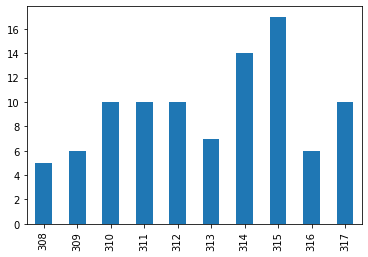

In [180]:
agg2[agg2['S'] == 'NVDA']['Result'].plot(kind='bar')

In [173]:
agg3 = agg1.groupby('S')['Result'].sum().reset_index()

In [174]:
agg3.sort_values(by=['Result'], ascending=False)

,S,Result
15,GOOGL,125
25,MRK,117
14,GOOG,117
34,TMO,117
19,JPM,114
3,AMGN,112
18,JNJ,108
24,MCD,108
2,ADBE,106
17,HON,106


In [177]:
len(stockwise[stockwise['S'] == 'GOOGL'])

200

In [178]:
125/200

0.625

In [186]:
tp = len(stockwise[(stockwise['Result'] == 1) & (stockwise['A'] == 5) & (stockwise['S'] == 'NVDA')])
fp = len(stockwise[(stockwise['Result'] == 1) & (stockwise['A'] == -5) & (stockwise['S'] == 'NVDA')])
tp/(tp+fp)

0.5714285714285714

In [189]:
tn = len(stockwise[(stockwise['Result'] == 1) & (stockwise['A'] == -5) & (stockwise['S'] == 'NVDA')])
fn = len(stockwise[(stockwise['Result'] == 1) & (stockwise['A'] == 5) & (stockwise['S'] == 'NVDA')])
tn/(tn+fn)

0.42857142857142855

In [194]:
sym = 'NVDA'
df = load_yahoo_data('/Users/partha/Downloads/0-DTE/Stocks/sp500/{}-20Year.csv'.format(sym))
test_df = df[-20:]
            #print ("{} {}".format(type(test_df), len(test_df)))
model = json.loads(open('/Users/partha/Downloads/0-DTE/Stocks/sp500-models-cleaned/{}.json'.format(sym)).read())
match = test_a_segment(date, test_df, model, 20)
match

{'Sequence': [0, 2, 3, 7, 6, 6, 6, 9, 9, 9, 9, 8, 11, 12, 15, 17, 10, 8, 5, 9],
 'Start date': '2020-08-12',
 'End Date': '2020-09-09',
 'Start Time': '00:00',
 'End Time': '00:00',
 'Distance': 11.269427669584644}